## EDA Dataset

In [49]:
import json
import re
import pandas as pd
from pandas import json_normalize
import numpy as np
import os
import datetime
import time
import spacy
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.legend import Legend
from matplotlib.gridspec import GridSpec

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k_checked_v3.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

def pre_process(text):
    '''function that normalize the text'''
    text = str(text)                             # Converting texto into string
    text = re.sub(r'[^\w\s]', ' ', text)         # Remove all the special characters
    return text

def fechas(df, column_to_look):
    '''Agrupa y cuenta los datos en diferentes periodos y los agrega al dataframe original'''
    column_to_look = str(column_to_look)
    df['datetime'] = pd.to_datetime(df[column_to_look],format='%Y-%m-%d').dt.date
    df['dia'] = pd.to_datetime(df[column_to_look], dayfirst=True).dt.day.astype('int')
    df['semana'] = pd.to_datetime(df[column_to_look], dayfirst=True).dt.isocalendar().week
    df['mes'] = pd.to_datetime(df[column_to_look], dayfirst=True).dt.month.astype('int')
    df['ano'] = pd.to_datetime(df[column_to_look], dayfirst=True).dt.year.astype('int')
    return df

def clean_flattern_json(df):
    #1st normalization: flatten columns with json files
    dfp = json_normalize(df)
    #2nd normalization: flatten nested columns with json files
    nested_columns = ['non_mercado_pago_payment_methods', 'pictures']
    for col in nested_columns:
        df_col = json_normalize(df, record_path=col)
        columns_name = df_col.columns
        for ncols in columns_name:
            dfp[col+'.'+ncols] = df_col[ncols]
    #remove nested columns 
    dfp.drop(nested_columns, axis='columns', inplace=True)
    #3rd normalization: remove special characters from columns
    columns_with_special_characters = ['sub_status',
                                       'deal_ids',
                                       'variations',
                                       'attributes',
                                       'tags',
                                       'coverage_areas',
                                       'descriptions',
                                       'shipping.methods',
                                       'shipping.tags']
    for col in columns_with_special_characters:
        dfp[col] = dfp[col].apply(pre_process)
    return dfp

In [31]:
def Histogram_plot(ax, df, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, stats):  
    ''' Compute an 1-D histogram with '''
    ax.set_title(title_name, size=20, color='k')
    plt.xlabel(xaxis_name, fontsize=18)
    plt.ylabel(yaxis_name, fontsize=18)
    plt.xlim(min_bin, max_bin)
    if log_axis:
        plt.yscale('log')

    max_val = df.max()
    min_val = df.min()
    nbins = int((max_val-min_val)/bin_size)  #numero de bins

    y_axis, bins, patches = plt.hist(x=df, bins=nbins, histtype='barstacked', color='royalblue', rwidth=1)
    
    max_y_val = max(y_axis)
    
    main_values = df.describe() 
    media = main_values['mean'] # Mean value
    Q1 = main_values['25%']     # Percentile 25
    Q2 = main_values['50%']     # Percentile 50
    Q3 = main_values['75%']     # Percentile 75
    
    ## Show the descriptive values computed above on the upper right sector of the plot
    if stats:
        if log_axis:
            ax.text(max_val*0.8, max_y_val*1.0, 'q25: {:.2f}'.format(Q1), size=10, color='k')
            ax.text(max_val*0.8, max_y_val*0.6, 'q50: {:.2f}'.format(Q2), size=10, color='k')
            ax.text(max_val*0.8, max_y_val*0.3, 'q75: {:.2f}'.format(Q3), size=10, color='k')
            ax.text(max_val*0.8, max_y_val*0.15, 'X: {:.2f}'.format(media), size=10, color='r')
        else:
            ax.text(max_val*0.8, max_y_val*1.0, 'q25: {:.2f}'.format(Q1), size=10, color='k')
            ax.text(max_val*0.8, max_y_val*0.9, 'q50: {:.2f}'.format(Q2), size=10, color='k')
            ax.text(max_val*0.8, max_y_val*0.8, 'q75: {:.2f}'.format(Q3), size=10, color='k')
            ax.text(max_val*0.8, max_y_val*0.7, 'X: {:.2f}'.format(media), size=10, color='r')

    ax.spines['right'].set_color('w')
    ax.spines['top'].set_color('w')

def Histogram_datetime_plot(ax, df, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, col):  
    ''' Compute an 1-D histogram with '''
    ax.set_title(title_name, size=20, color='k')
    plt.xlabel(xaxis_name, fontsize=18)
    plt.ylabel(yaxis_name, fontsize=18)
    plt.xlim(min_bin, max_bin)
    if log_axis:
        plt.yscale('log')

    max_val = df[col].max()
    min_val = df[col].min()
    nbins = int((max_val-min_val)/bin_size)  #numero de bins

    colors = ['royalblue','lightgreen','darkorange']
    #for i, a in enumerate(df.ano.unique()):
        #y_axis, bins, patches = plt.hist(x=df[df['ano'] == a][col], bins=nbins, histtype='barstacked', color=colors[i], rwidth=1)
    y_axis, bins, patches = plt.hist(x=df[col], bins=nbins, histtype='barstacked', color='royalblue', rwidth=1)
        
    ax.spines['right'].set_color('w')
    ax.spines['top'].set_color('w')

def Barh_plot(ax, df, title_name):
    ''' Horizontal bar plot '''
    categories = df.value_counts().index.tolist()
    values = df.value_counts().tolist()
    values_total = sum(values)
    values_perc = [100*i/values_total for i in values]
    
    ax.set_title(title_name, size=20, color='k')
    
    plt.barh(categories, values_perc, color ='royalblue')
    
    for i, v in enumerate(values_perc):
        ax.text(v+0.2, i, str(round(v, 2))+'%', color='k', va="center")
 
    ax.spines['right'].set_color('w')
    ax.spines['bottom'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.tick_params(axis='x', colors='w')
    
def Pie_plot(ax, df, title_name, explode, colors):
    ''' Pie plot '''
    categories = df.value_counts().index.tolist()
    values = df.value_counts().tolist()
    
    ax.set_title(title_name, size=20, color='k')
    
    ax.pie(values, explode=explode, labels=categories, autopct='%1.2f%%', shadow=True, startangle=0, colors= colors, textprops={'fontsize': 12})

def Barh_plot_custom_list(ax, df, title_name, list_of_bars):
    ''' Horizontal bar plot '''
    values = []
    for element in list_of_bars:
        number = df.tolist().count(element)
        values.append(number)  
    values_total = sum(values)
    values_perc = [100*i/values_total for i in values]
    list_of_bars = [str(x) for x in list_of_bars]
    ax.set_title(title_name, size=20, color='k')
    
    plt.barh(list_of_bars, values_perc, color ='royalblue')
    
    for i, v in enumerate(values_perc):
        ax.text(v+0.2, i, str(round(v, 2))+'%', color='k', va="center")
 
    ax.spines['right'].set_color('w')
    ax.spines['bottom'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.tick_params(axis='x', colors='w')    

def Plot_numerical_data(arg00, arg01, arg02, arg03, arg04, arg05):
    ''' Show a dashboard with all features related to bank client data '''
    fig = plt.figure(figsize=(25,15))
    gs = GridSpec(nrows=2, ncols=3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
    gs.update(wspace = 0.3, hspace = 0.45)

    plt.title('Numerical features', fontsize=30, x=0.5, y=1.06)
   
    all_axes = fig.get_axes()
    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

    ########### Base Price #####################
    df00 = arg00[0]
    bin_size = arg00[1]
    min_bin = arg00[2]
    max_bin = arg00[3]
    title_name = arg00[4]
    xaxis_name = arg00[5]
    yaxis_name = arg00[6]
    log_axis = arg00[7]
    stats = arg00[8]
    
    ax00 = fig.add_subplot(gs[0,0])
    
    Histogram_plot(ax00, df00, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, stats)

    ######### Price #########################
    
    df01 = arg01[0]
    bin_size = arg01[1]
    min_bin = arg01[2]
    max_bin = arg01[3]
    title_name = arg01[4]
    xaxis_name = arg01[5]
    yaxis_name = arg01[6]
    log_axis = arg01[7]
    stats = arg01[8]
    
    ax01 = fig.add_subplot(gs[0,1])
    
    Histogram_plot(ax01, df01, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, stats)
  
    ######### Time Difference #########################
    df02 = arg02[0]
    bin_size = arg02[1]
    min_bin = arg02[2]
    max_bin = arg02[3]
    title_name = arg02[4]
    xaxis_name = arg02[5]
    yaxis_name = arg02[6]
    log_axis = arg02[7]
    stats = arg02[8]
    
    ax02 = fig.add_subplot(gs[0,2])
    
    Histogram_plot(ax02, df02, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, stats)
   
    ######### Initial Quantity #########################
    df03 = arg03[0]
    bin_size = arg03[1]
    min_bin = arg03[2]
    max_bin = arg03[3]
    title_name = arg03[4]
    xaxis_name = arg03[5]
    yaxis_name = arg03[6]
    log_axis = arg03[7]
    stats = arg03[8]
    
    ax03 = fig.add_subplot(gs[1,0])
    
    Histogram_plot(ax03, df03, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, stats)
    
    ######### Sold Quantity #########################
    df04 = arg04[0]
    bin_size = arg04[1]
    min_bin = arg04[2]
    max_bin = arg04[3]
    title_name = arg04[4]
    xaxis_name = arg04[5]
    yaxis_name = arg04[6]
    log_axis = arg04[7]
    stats = arg04[8]
    
    ax04 = fig.add_subplot(gs[1,1])
    
    Histogram_plot(ax04, df04, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, stats)
    
    ######### Available Quantity #########################
    df05 = arg05[0]
    bin_size = arg05[1]
    min_bin = arg05[2]
    max_bin = arg05[3]
    title_name = arg05[4]
    xaxis_name = arg05[5]
    yaxis_name = arg05[6]
    log_axis = arg05[7]
    stats = arg05[8]
    
    ax05 = fig.add_subplot(gs[1,2])
    
    Histogram_plot(ax05, df05, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, stats)
    
    return

def Plot_date_data(arg00, arg01, arg02, arg03): 
    ''' Show a dashboard with all features related to bank client data '''
    fig = plt.figure(figsize=(20,6))
    gs = GridSpec(nrows=1, ncols=4, width_ratios=[1, 1, 1, 1], height_ratios=[1])
    gs.update(wspace = 0.3, hspace = 0.45)

    #plt.title('Clients Data', fontsize=30, x=0.5, y=1.06)
   
    all_axes = fig.get_axes()
    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

    ######### dia #########################
    df00 = arg00[0]
    bin_size = arg00[1]
    min_bin = arg00[2]
    max_bin = arg00[3]
    title_name = arg00[4]
    xaxis_name = arg00[5]
    yaxis_name = arg00[6]
    log_axis = arg00[7]
    col = arg00[8]
    
    ax00 = fig.add_subplot(gs[0,0])
    
    Histogram_datetime_plot(ax00, df00, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, col)
    
    ######### semana #########################
    df01 = arg01[0]
    bin_size = arg01[1]
    min_bin = arg01[2]
    max_bin = arg01[3]
    title_name = arg01[4]
    xaxis_name = arg01[5]
    yaxis_name = arg01[6]
    log_axis = arg01[7]
    col = arg01[8]
    
    ax01 = fig.add_subplot(gs[0,1])
    
    Histogram_datetime_plot(ax01, df01, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, col)
    
    ######### mes #########################
    df02 = arg02[0]
    bin_size = arg02[1]
    min_bin = arg02[2]
    max_bin = arg02[3]
    title_name = arg02[4]
    xaxis_name = arg02[5]
    yaxis_name = arg02[6]
    log_axis = arg02[7]
    col = arg02[8]
    
    ax02 = fig.add_subplot(gs[0,2])
    
    Histogram_datetime_plot(ax02, df02, title_name, xaxis_name, yaxis_name, min_bin, max_bin, bin_size, log_axis, col) 
    
    ######### ano #########################
    ax03 = fig.add_subplot(gs[0,3])
    df03 = arg03[0]
    title_name = arg03[1]
    labels = df03.unique()
    
    Barh_plot_custom_list(ax03, df03, title_name, labels)
    
    return

def Plot_categorical_data(arg00, arg01, arg02, arg03, arg04, arg05): 
    ''' Show a dashboard with all features related to bank client data '''
    fig = plt.figure(figsize=(25,15))
    gs = GridSpec(nrows=2, ncols=3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
    gs.update(wspace = 0.3, hspace = 0.45)

    plt.title('Categorical Data', fontsize=30, x=0.5, y=1.06)
   
    all_axes = fig.get_axes()
    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

    ######### sub_status #########################
    ax00 = fig.add_subplot(gs[0,0])
    df00 = arg00[0]
    title_name = arg00[1]
    labels = df00.unique()
    
    Barh_plot_custom_list(ax00, df00, title_name, labels)
    
    ######### buying_mode #########################
    ax01 = fig.add_subplot(gs[0,1])
    df01 = arg01[0]
    title_name = arg01[1]
    labels = df01.unique()
    
    Barh_plot_custom_list(ax01, df01, title_name, labels)
    
    ######### accepts_mercadopago #########################
    ax02 = fig.add_subplot(gs[0,2])
    df02 = arg02[0]
    title_name = arg02[1]
    colors = ['limegreen','royalblue']
    
    explode = (0, 0)
    Pie_plot(ax02, df02, title_name, explode, colors)
    
    ######### currency_id #########################
    ax03 = fig.add_subplot(gs[1,0])
    df03 = arg03[0]
    title_name = arg03[1]
    colors = ['limegreen','royalblue']
    
    explode = (0, 0)
    Pie_plot(ax03, df03, title_name, explode, colors)

    ######### automatic_relist #########################
    ax04 = fig.add_subplot(gs[1,1])
    df04 = arg04[0]
    title_name = arg04[1]
    colors = ['limegreen','royalblue']
    
    explode = (0, 0)
    Pie_plot(ax04, df04, title_name, explode, colors)
    
    ######### status #########################
    ax05 = fig.add_subplot(gs[1,2])
    df05 = arg05[0]
    title_name = arg05[1]
    labels = df05.unique()
    
    Barh_plot_custom_list(ax05, df05, title_name, labels)
    
    return

def Plot_seller_address(arg00): 
    ''' Show a dashboard with all features related to bank client data '''
    fig = plt.figure(figsize=(6,6))
    gs = GridSpec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
    gs.update(wspace = 0.3, hspace = 0.45)

    #plt.title('Clients Data', fontsize=30, x=0.5, y=1.06)
   
    all_axes = fig.get_axes()
    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

    ######### seller_address.state.name #########################
    ax00 = fig.add_subplot(gs[0,0])
    df00 = arg00[0]
    title_name = arg00[1]
    labels = df00.unique()
    
    Barh_plot_custom_list(ax00, df00, title_name, labels)
    
    return

def Plot_shipping_data(arg00, arg01, arg02): 
    ''' Show a dashboard with all features related to bank client data '''
    fig = plt.figure(figsize=(20,6))
    gs = GridSpec(nrows=1, ncols=3, width_ratios=[1, 1, 1], height_ratios=[1])
    gs.update(wspace = 0.3, hspace = 0.45)

    #plt.title('Clients Data', fontsize=30, x=0.5, y=1.06)
   
    all_axes = fig.get_axes()
    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

    ######### shipping.local_pick_up #########################
    ax00 = fig.add_subplot(gs[0,0])
    df00 = arg00[0]
    title_name = arg00[1]
    colors = ['limegreen','royalblue']
    
    explode = (0, 0)
    Pie_plot(ax00, df00, title_name, explode, colors)
    
    ######### shipping.free_shipping #########################
    ax01 = fig.add_subplot(gs[0,1])
    df01 = arg01[0]
    title_name = arg01[1]
    colors = ['limegreen','royalblue']
    
    explode = (0, 0)
    Pie_plot(ax01, df01, title_name, explode, colors)
    
    ######### shipping.mode #########################
    ax02 = fig.add_subplot(gs[0,2])
    df02 = arg02[0]
    title_name = arg02[1]
    labels = df02.unique()
    
    Barh_plot_custom_list(ax02, df02, title_name, labels)
    
    return

def Plot_non_mercado_pago_payment_methods_data(arg00, arg01): 
    ''' Show a dashboard with all features related to bank client data '''
    fig = plt.figure(figsize=(15,6))
    gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1], height_ratios=[1])
    gs.update(wspace = 0.3, hspace = 0.45)

    #plt.title('Clients Data', fontsize=30, x=0.5, y=1.06)
   
    all_axes = fig.get_axes()
    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

    ######### non_mercado_pago_payment_methods.description #########################
    ax00 = fig.add_subplot(gs[0,0])
    df00 = arg00[0]
    title_name = arg00[1]
    labels = df00.unique()
    
    Barh_plot_custom_list(ax00, df00, title_name, labels)
    
    ######### non_mercado_pago_payment_methods.type #########################
    ax01 = fig.add_subplot(gs[0,1])
    df01 = arg01[0]
    title_name = arg01[1]
    labels = df01.unique()
    
    Barh_plot_custom_list(ax01, df01, title_name, labels)
    
    return

def Correlation_matrix(df):
    corrmat = df.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(13,10))
    #plot heat map
    g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="Blues")
    return

def Feature_importance(X, y):
    n_features = len(X.columns)
    model = ExtraTreesClassifier()
    model.fit(X,y)
    #print(model.feature_importances_)
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(n_features).plot(kind='barh')
    plt.show()
    return

In [4]:
X_train, y_train, X_test, y_test = build_dataset()
    
X_train_df = clean_flattern_json(X_train)
X_train_df = fechas(X_train_df, 'date_created')
X_train_df['diff_time'] = X_train_df['stop_time'] - X_train_df['start_time']
    
X_test_df = clean_flattern_json(X_test)
X_test_df = fechas(X_test_df, 'date_created')
X_test_df['diff_time'] = X_test_df['stop_time'] - X_test_df['start_time']

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
X_train_df.head(2)

,warranty,sub_status,condition,deal_ids,base_price,seller_id,variations,site_id,listing_type_id,price,attributes,buying_mode,tags,listing_source,parent_item_id,coverage_areas,category_id,descriptions,last_updated,international_delivery_mode,id,official_store_id,differential_pricing,accepts_mercadopago,original_price,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity,seller_address.country.name,seller_address.country.id,seller_address.state.name,seller_address.state.id,seller_address.city.name,seller_address.city.id,shipping.local_pick_up,shipping.methods,shipping.tags,shipping.free_shipping,shipping.mode,shipping.dimensions,shipping.free_methods,non_mercado_pago_payment_methods.description,non_mercado_pago_payment_methods.id,non_mercado_pago_payment_methods.type,pictures.size,pictures.secure_url,pictures.max_size,pictures.url,pictures.quality,pictures.id,datetime,dia,semana,mes,ano,diff_time
0,None,,new,,80.0,8208882349,,MLA,bronze,80.0,,buy_it_now,dragged_bids_and_visits,,MLA6553902747,,MLA126406,id MLA4695330653 912855983,2015-09-05T20:42:58.000Z,none,MLA4695330653,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05T20:42:53.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1446669773000,active,None,NaN,None,1,1441485773000,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1,Argentina,AR,Capital Federal,AR-C,San Cristóbal,TUxBQlNBTjkwNTZa,True,,,False,not_specified,None,NaN,Transferencia bancaria,MLATB,G,500x375,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1200x900,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,,5386-MLA4695330653_052013,2015-09-05,5,36,9,2015,5184000000
1,NUESTRA REPUTACION,,used,,2650.0,8141699488,,MLA,silver,2650.0,,buy_it_now,,,MLA7727150374,,MLA10267,id MLA7160447179 930764806,2015-09-26T18:08:34.000Z,none,MLA7160447179,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26T18:08:30.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1448474910000,active,None,NaN,None,1,1443290910000,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1,Argentina,AR,Capital Federal,AR-C,Buenos Aires,,True,,,False,me2,None,NaN,Acordar con el comprador,MLAWC,G,500x375,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1200x900,http://mla-s1-p.mlstatic.com/5361-MLA469533065...,,5361-MLA4695330653_052013,2015-09-26,26,39,9,2015,5184000000


## Features of the dataset
En este conjunto de datos encontramos 3 tipos de features: Numericas, Categoricas y Booleanas

Las variables Numéricas que consideraremos son aquellas que no contienen missing values:  
- base_price
- price
- seller_id
- start_time
- stop_time
- initial_quantity
- sold_quantity 
- available_quantity
Además consideraremos una nueva columna creada a partir de la diferencia de tiempo entre stop_time y start_time llamada diff_time
- diff_time

Las variables Categoricas que consideraremos son aquellas que no contienen missing values, que no contienen valores en blanco o que no contienen todos los datos iguales (Además no consideraré las categoeías asociadas a pictures):
- listing_type_id 
- buying_mode 
- accepts_mercadopago
- currency_id
- automatic_relist
- status
- seller_address.state.name
- seller_address.city.name
- shipping.local_pick_up 
- shipping.free_shipping
- shipping.mode
- non_mercado_pago_payment_methods.description
- non_mercado_pago_payment_methods.type

Finalmente las variables Booleanas son:

- accepts_mercadopago                              
- automatic_relist                                
- shipping.local_pick_up                          
- shipping.free_shipping   

Además consideraremos la columna date_created donde extraeremos la información por dia, semana, mes y año creando las nuevas features:

- dia
- semana
- mes
- ano

Variable a predecir:
- condition 

In [10]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 69 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   warranty                                      35243 non-null  object 
 1   sub_status                                    90000 non-null  object 
 2   condition                                     90000 non-null  object 
 3   deal_ids                                      90000 non-null  object 
 4   base_price                                    90000 non-null  float64
 5   seller_id                                     90000 non-null  int64  
 6   variations                                    90000 non-null  object 
 7   site_id                                       90000 non-null  object 
 8   listing_type_id                               90000 non-null  object 
 9   price                                         90000 non-null 

## Numerical Features

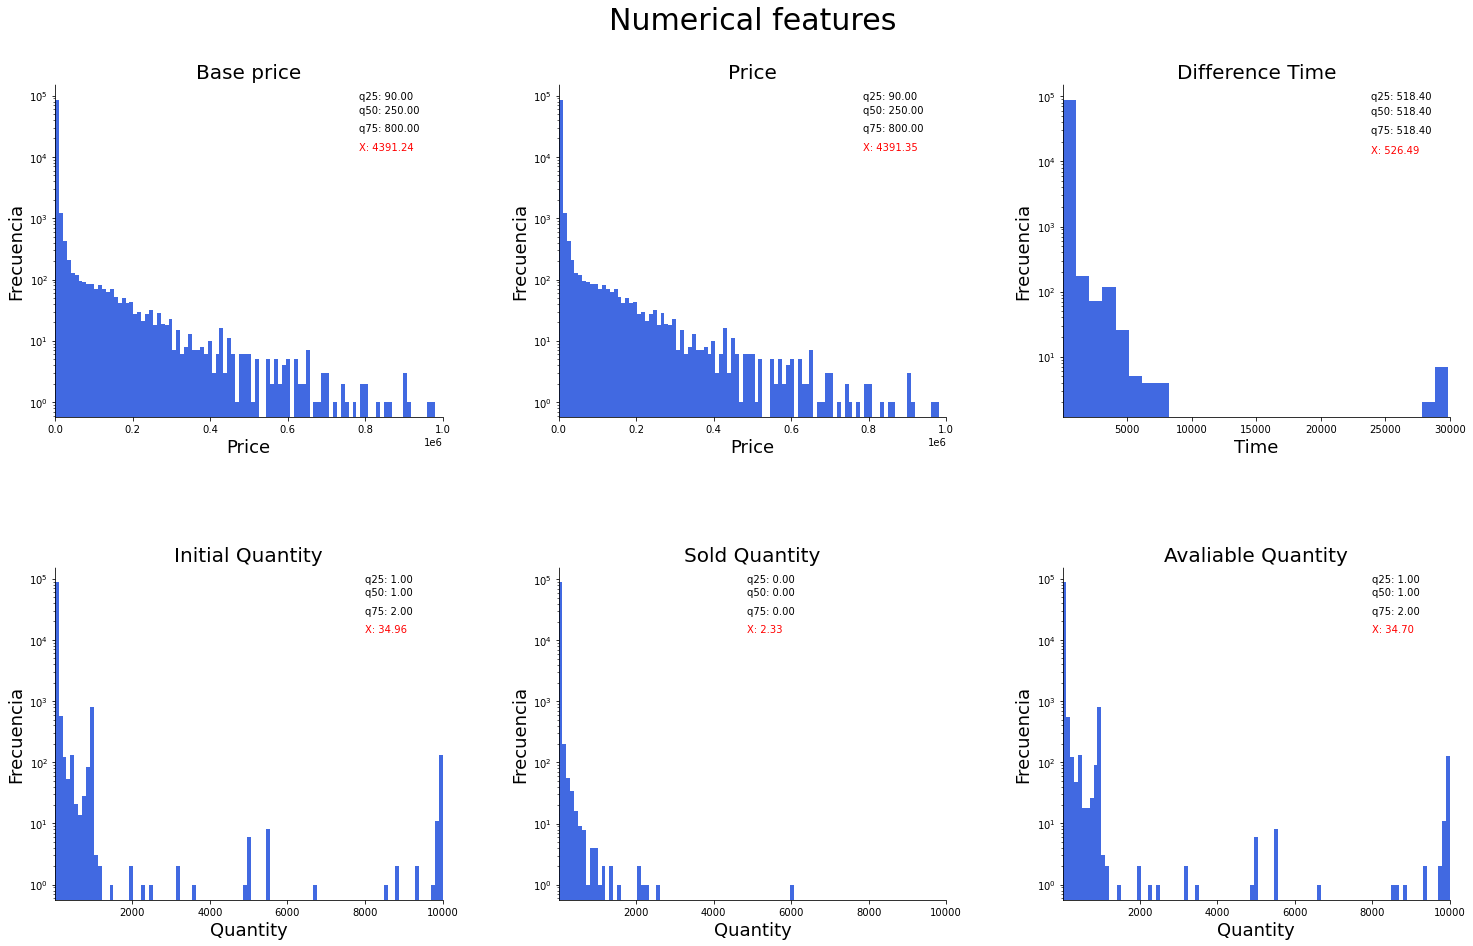

In [14]:
# Numerical features
base_price_plot = [X_train_df[X_train_df.base_price < 1000000].base_price, 10000, 0, 1000000, "Base price", 'Price', 'Frecuencia', True, True]
price_plot = [X_train_df[X_train_df.price < 1000000].price, 10000, 0, 1000000, "Price", 'Price', 'Frecuencia', True, True]
diff_time_plot = [X_train_df.diff_time/1e7, 1000, 1, 3e4, "Difference Time", 'Time', 'Frecuencia', True, True]
init_quantity_plot = [X_train_df.initial_quantity, 100, 10, 1e4, "Initial Quantity", 'Quantity', 'Frecuencia', True, True]
sold_quantity_plot = [X_train_df.sold_quantity, 100, 10, 1e4, "Sold Quantity", 'Quantity', 'Frecuencia', True, True]
available_quantity_plot = [X_train_df.available_quantity, 100, 10, 1e4, "Avaliable Quantity", 'Quantity', 'Frecuencia', True, True]

Plot_numerical_data(base_price_plot, 
                    price_plot, 
                    diff_time_plot, 
                    init_quantity_plot,
                    sold_quantity_plot,
                    available_quantity_plot)

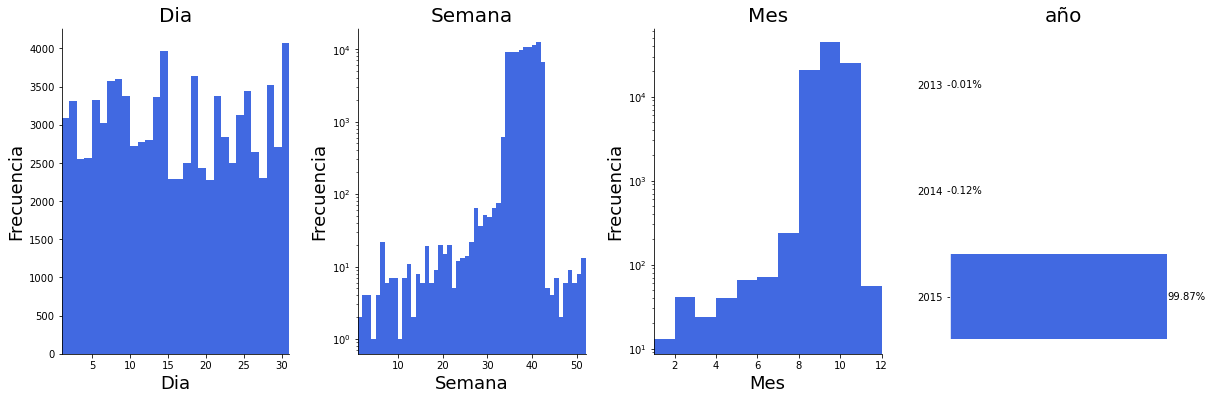

In [17]:
dia_plot = [X_train_df[['dia','ano']], 1, 1, 31, "Dia", 'Dia', 'Frecuencia', False, 'dia']
semana_plot = [X_train_df[['semana','ano']], 1, 1, 52, "Semana", 'Semana', 'Frecuencia', True, 'semana']
mes_plot = [X_train_df[['mes','ano']], 1, 1, 12, "Mes", 'Mes', 'Frecuencia', True, 'mes']
ano_plot = [X_train_df.ano, 'año']

Plot_date_data(dia_plot, semana_plot, mes_plot, ano_plot)

### Correlación de variables

Podemos entender que variables están correlacionadas entre si, y de esa manera eliminar las variables redundantes, es decir, que aportan la misma información al modelo, pudiendo generar overffiting durante el proceso de entrenamiento.
Existe una correlación muy fuerte entre base_price y base, al igual que entre initial_quantity y available_quantity

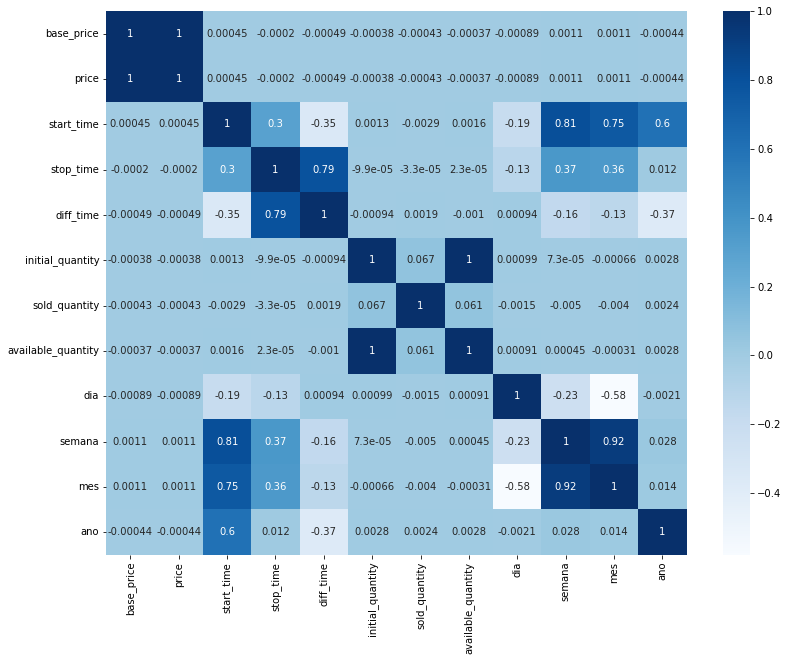

In [20]:
Correlation_matrix(X_train_df[['base_price','price','start_time','stop_time','diff_time','initial_quantity','sold_quantity','available_quantity','dia','semana','mes','ano']])

### Importancia de las variables
Podemos calcular el grado de importancia que aporta cada variable al modelo a entrenar pudiendo observar que las variables asociadas a fecha: dia, semana, mes, año y diff_time, no son muy importantes para el resultado del modelo

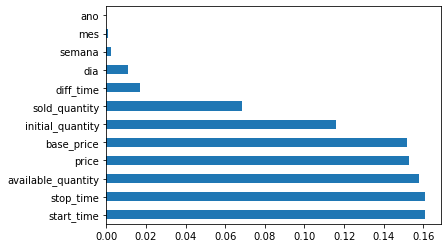

In [25]:
Feature_importance(X_train_df[['base_price','price','start_time','stop_time','diff_time','initial_quantity','sold_quantity','available_quantity','dia','semana','mes','ano']], y_train)

## Categorical Variables

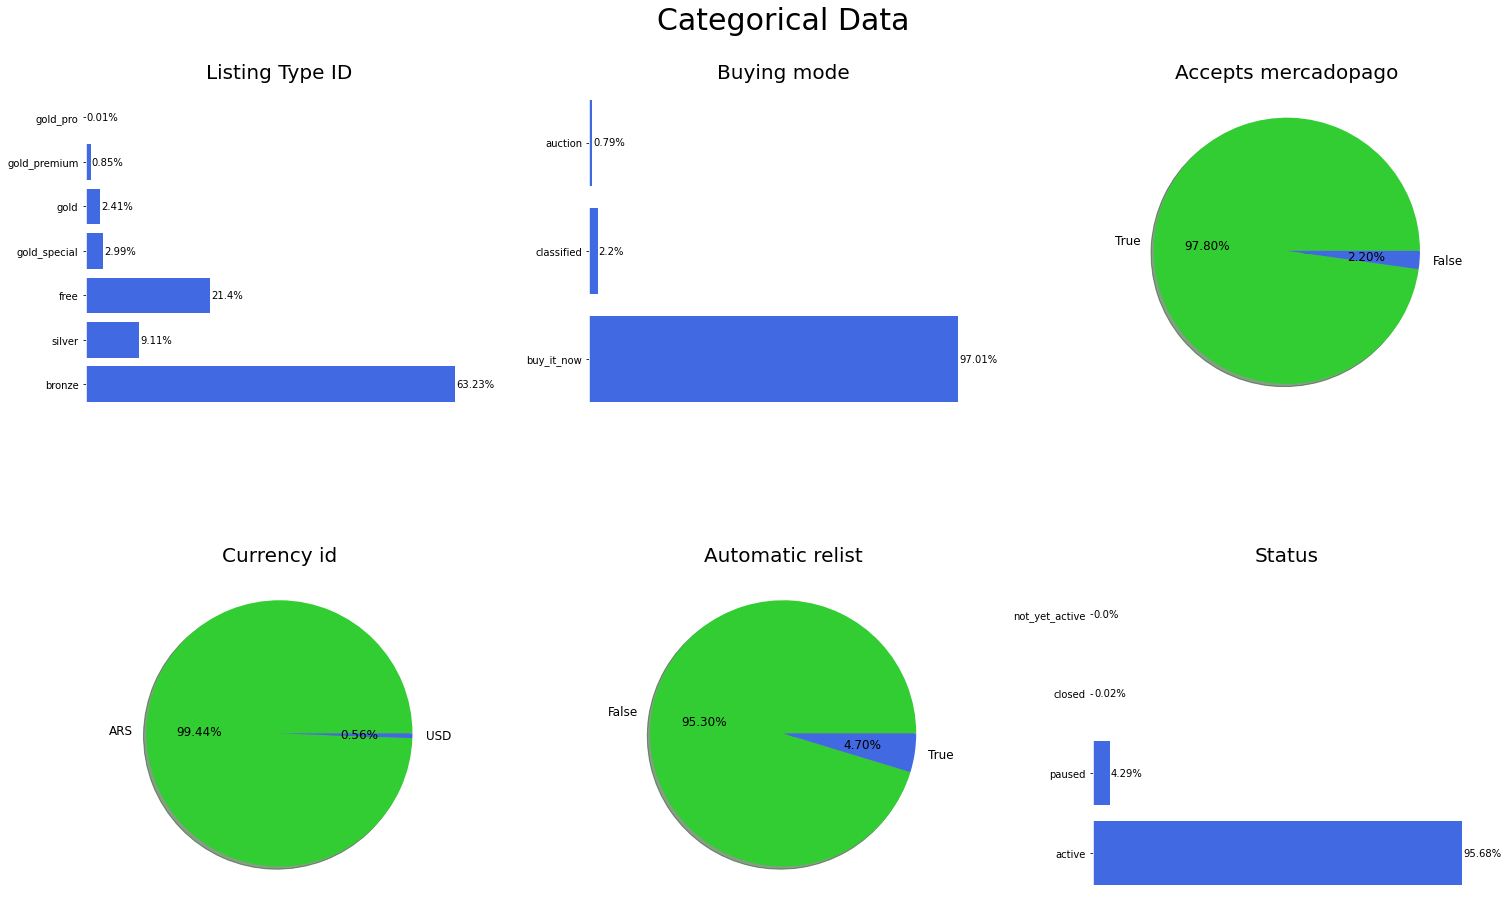

In [32]:
# Categorical features
sub_status_plot = [X_train_df.listing_type_id, 'Listing Type ID']
buying_mode_plot = [X_train_df.buying_mode, 'Buying mode']
accepts_mercadopago_plot = [X_train_df.accepts_mercadopago, 'Accepts mercadopago']
currency_plot = [X_train_df.currency_id, 'Currency id']
automatic_relist_plot = [X_train_df.automatic_relist, 'Automatic relist']
status_plot = [X_train_df.status, 'Status']

Plot_categorical_data(sub_status_plot, 
                      buying_mode_plot, 
                      accepts_mercadopago_plot, 
                      currency_plot,
                      automatic_relist_plot,
                      status_plot)

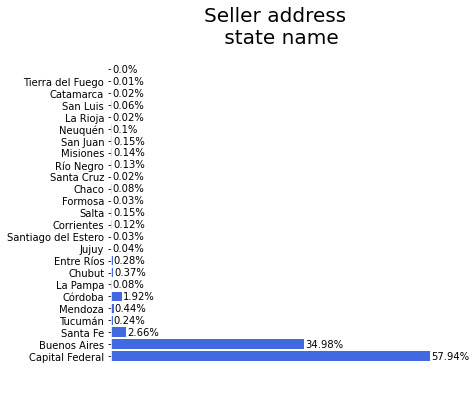

In [28]:
seller_address_plot = [X_train_df['seller_address.state.name'], 'Seller address \n state name']
Plot_seller_address(seller_address_plot)

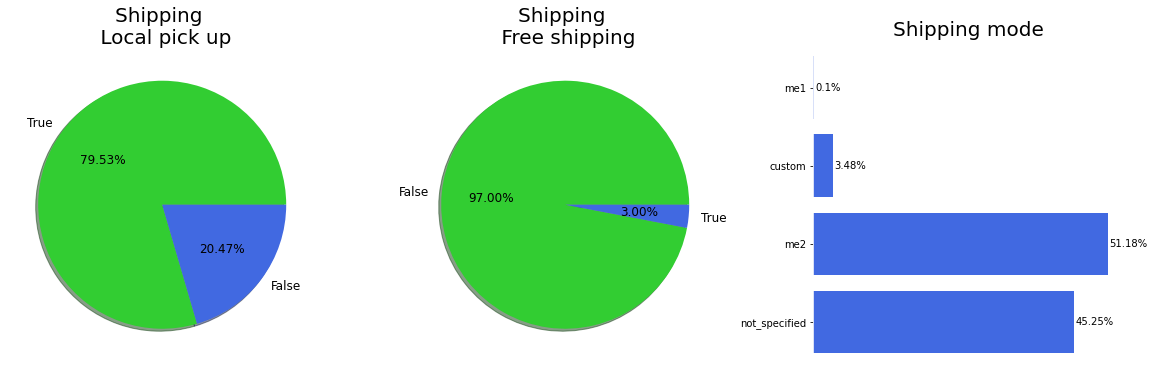

In [29]:
local_pick_up_plot = [X_train_df['shipping.local_pick_up'], 'Shipping \n Local pick up']
free_shipping_plot = [X_train_df['shipping.free_shipping'], 'Shipping \n Free shipping']
shipping_mode_plot = [X_train_df['shipping.mode'], 'Shipping mode']

Plot_shipping_data(local_pick_up_plot, 
                   free_shipping_plot,
                   shipping_mode_plot)

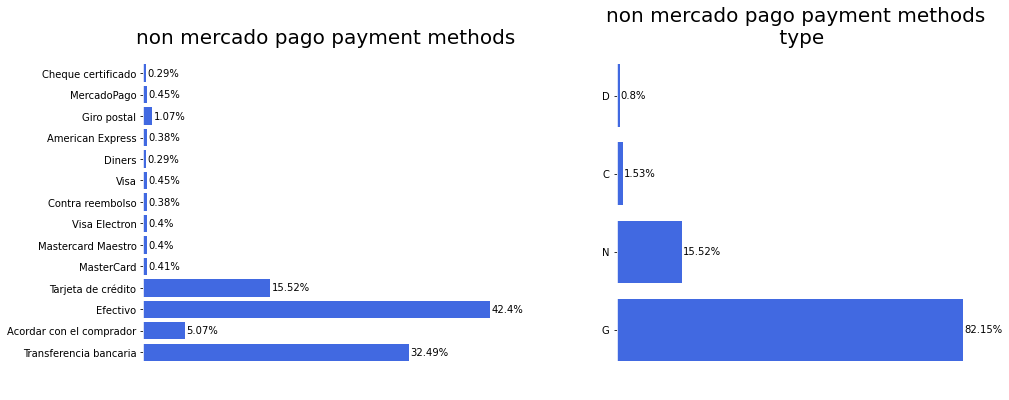

In [30]:
description_plot = [X_train_df['non_mercado_pago_payment_methods.description'], 'non mercado pago payment methods']
type_plot = [X_train_df['non_mercado_pago_payment_methods.type'], 'non mercado pago payment methods \n type']

Plot_non_mercado_pago_payment_methods_data(description_plot, type_plot)

### Features que usaremos para entrenar el modelo

In [33]:
numerical_columns = ['stop_time',
                     'start_time',
                     'available_quantity',
                     'price',
                     'initial_quantity',
                     'sold_quantity']

In [34]:
categorical_columns = ['listing_type_id', 
                       'buying_mode', 
                       'accepts_mercadopago', 
                       'currency_id', 
                       'automatic_relist', 
                       'status',
                       'seller_address.state.name',
                       'seller_address.city.name',
                       'shipping.local_pick_up', 
                       'shipping.free_shipping', 
                       'shipping.mode',
                       'non_mercado_pago_payment_methods.description',
                       'non_mercado_pago_payment_methods.type']

Vamos a concatenar el dataset de entrenamiento (X_train) y el dataset de validación (X_test) para poder transformar las variables categóricas en números. Para ello usaremos la técnica de OneHotEncoder y crear una matriz de 0 y 1 que nos permitan crear el dataset de input del modelo. Además las variables booleanas las transformaremos en strings para poder aplicar el OneHotEncoder también.

In [37]:
X_full_df = pd.concat([X_train_df, X_test_df], axis=0)
X_full_num = X_full_df[numerical_columns]
X_full_cat = X_full_df[categorical_columns]

In [38]:
boolean_features = ['accepts_mercadopago','automatic_relist','shipping.local_pick_up','shipping.free_shipping']
for col in boolean_features:
    X_full_cat[col] = X_full_cat[col].map({True: 'True', False: 'False'}) 

/var/folders/7r/yr3pw2hs5nzbzddc5tx7dspw0000gn/T/ipykernel_67282/595601808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_full_cat[col] = X_full_cat[col].map({True: 'True', False: 'False'})
/var/folders/7r/yr3pw2hs5nzbzddc5tx7dspw0000gn/T/ipykernel_67282/595601808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_full_cat[col] = X_full_cat[col].map({True: 'True', False: 'False'})
/var/folders/7r/yr3pw2hs5nzbzddc5tx7dspw0000gn/T/ipykernel_67282/595601808.py:3: SettingWithCopyWarning: 
A value is t

In [41]:
vectorizer = OneHotEncoder()
X_full_categorical = vectorizer.fit_transform(X_full_cat).toarray()
X_full_numerical = X_full_num.to_numpy()
X_full = np.concatenate((X_full_numerical, X_full_categorical), axis=1)

Volvemos a separar el dataframe en X_train y X_test

In [42]:
X_train = X_full[:-10000]
X_test = X_full[-10000:]

# Modelos

### Logistic Regression

In [43]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y0_pred = lr_model.predict(X_test)
accuracy0 = accuracy_score(y_test, y0_pred)
print('Accuracy of the Logistic Regression model: {:.2f}%'.format(100*accuracy0))
print("Accuracy on training set: {:.2f}%".format(100*lr_model.score(X_test, y_test)))

Accuracy of the Logistic Regression model: 54.06%
Accuracy on training set: 54.06%


### Random Forest

In [44]:
rf_model = RandomForestClassifier(n_estimators=300, random_state=0)
rf_model.fit(X_train, y_train)
y1_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, y1_pred))
print('\nReporte de Clasificacion:')
print(classification_report(y_test, y1_pred))
accuracy1 = 100*accuracy_score(y_test, y1_pred)
print('Accuracy: {:.2f}%'.format(accuracy1))

[[4678  728]
 [ 659 3935]]

Reporte de Clasificacion:
              precision    recall  f1-score   support

         new       0.88      0.87      0.87      5406
        used       0.84      0.86      0.85      4594

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy: 86.13%


### Gradient Boosting

In [45]:
gbc_model = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=1, random_state=0)
gbc_model.fit(X_train, y_train)
y2_pred = gbc_model.predict(X_test)

print(confusion_matrix(y_test, y2_pred))
print('\nReporte de Clasificacion:')
print(classification_report(y_test, y2_pred))
accuracy2 = 100*accuracy_score(y_test, y2_pred)
print('Accuracy: {:.2f}%'.format(accuracy2))

[[4631  775]
 [ 747 3847]]

Reporte de Clasificacion:
              precision    recall  f1-score   support

         new       0.86      0.86      0.86      5406
        used       0.83      0.84      0.83      4594

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy: 84.78%


### XGBoost

In [46]:
#cambiar y_train a números
y_train_n = []
for val in y_train:
    if val == 'new': y_train_n.append(int(1))
    else: y_train_n.append(int(0))
y_train_n = np.array(y_train_n)

In [47]:
#cambiar y_test a números
y_test_n = []
for val in y_test:
    if val == 'new': y_test_n.append(int(1))
    else: y_test_n.append(int(0))
y_test_n = np.array(y_test_n)

In [48]:
xgb_model = XGBClassifier(n_estimators=300, learning_rate=1.0, max_depth=1, random_state=0)
xgb_model.fit(X_train, y_train_n)

y3_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test_n, y3_pred))
print('\nReporte de Clasificacion:')
print(classification_report(y_test_n, y3_pred))
accuracy3 = 100*accuracy_score(y_test_n, y3_pred)
print('Accuracy: {:.2f}%'.format(accuracy3))

[[3850  744]
 [ 781 4625]]

Reporte de Clasificacion:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      4594
           1       0.86      0.86      0.86      5406

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy: 84.75%


### Best Model
El mejor resultado fue obtenido por Random Forest model con una precision de 86.13%